In [1]:
# Title:  MLP: Multilayer Perceptron Neural Networks

# INSTALL AND LOAD PACKAGES ################################

# Install pacman if you don't have it (uncomment next line)
# install.packages("pacman")

# Install and/or load packages with pacman
pacman::p_load(  # Use p_load function from pacman
  datasets,      # R's built-in sample datasets
  magrittr,      # Pipes
  nnfor,         # Neural networks for time-series data
  pacman,        # Load/unload packages
  rio,           # Import/export data
  tidyverse      # So many reasons
)

also installing the dependencies ‘RcppParallel’, ‘lamW’, ‘texreg’, ‘greybox’, ‘pracma’, ‘smooth’, ‘Deriv’, ‘MAPA’, ‘neuralnet’, ‘plotrix’, ‘tsutils’, ‘uroot’





The downloaded binary packages are in
	/var/folders/rh/pfd6hrw52s35skb7d44l36nr0000gn/T//RtmppQgXj0/downloaded_packages



nnfor installed



In [2]:
# Set random seed for reproducibility in processes like
# splitting the data. You can use any number.
set.seed(1)

In [3]:
# LOAD AND PREPARE DATA ####################################

# Use `AirPassengers` data from R's `datasets` package
?AirPassengers

AirPassengers {datasets},R Documentation


In [4]:
# Save data to `df`, which allows code to be reused
df <- AirPassengers

In [5]:
# See data
df

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1949,112,118,132,129,121,135,148,148,136,119,104,118
1950,115,126,141,135,125,149,170,170,158,133,114,140
1951,145,150,178,163,172,178,199,199,184,162,146,166
1952,171,180,193,181,183,218,230,242,209,191,172,194
1953,196,196,236,235,229,243,264,272,237,211,180,201
1954,204,188,235,227,234,264,302,293,259,229,203,229
1955,242,233,267,269,270,315,364,347,312,274,237,278
1956,284,277,317,313,318,374,413,405,355,306,271,306
1957,315,301,356,348,355,422,465,467,404,347,305,336
1958,340,318,362,348,363,435,491,505,404,359,310,337


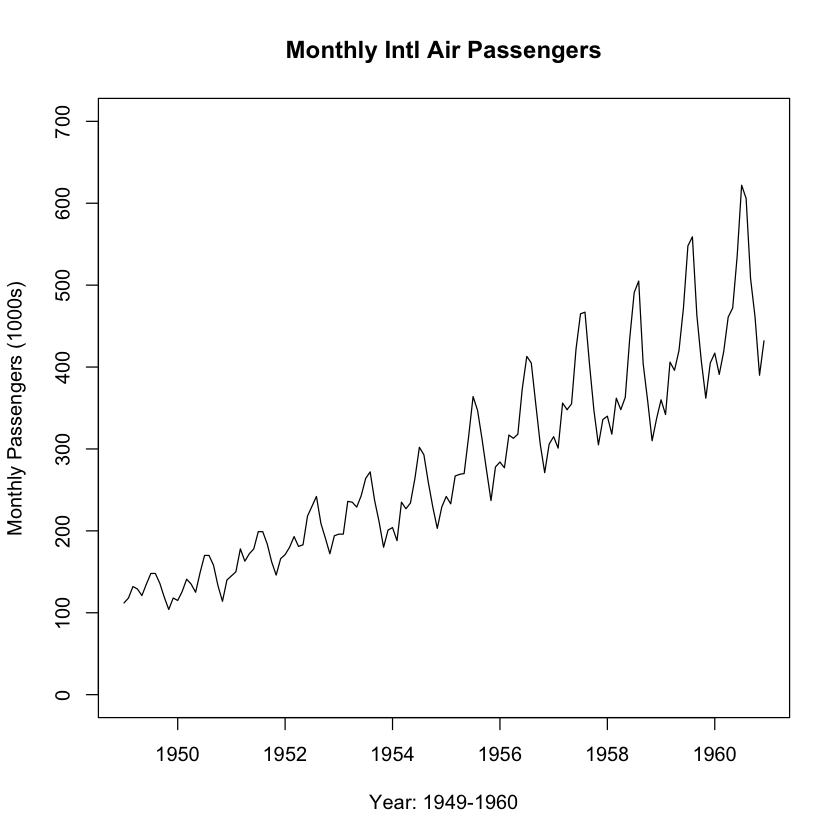

In [6]:
# Plot data
df %>%
  plot(
    main = "Monthly Intl Air Passengers",
    xlab = "Year: 1949-1960",
    ylab = "Monthly Passengers (1000s)",
    ylim = c(0, 700)
  )

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1949,112,118,132,129,121,135,148,148,136,119,104,118
1950,115,126,141,135,125,149,170,170,158,133,114,140
1951,145,150,178,163,172,178,199,199,184,162,146,166
1952,171,180,193,181,183,218,230,242,209,191,172,194
1953,196,196,236,235,229,243,264,272,237,211,180,201
1954,204,188,235,227,234,264,302,293,259,229,203,229
1955,242,233,267,269,270,315,364,347,312,274,237,278
1956,284,277,317,313,318,374,413,405,355,306,271,306
1957,315,301,356,348,355,422,465,467,404,347,305,336


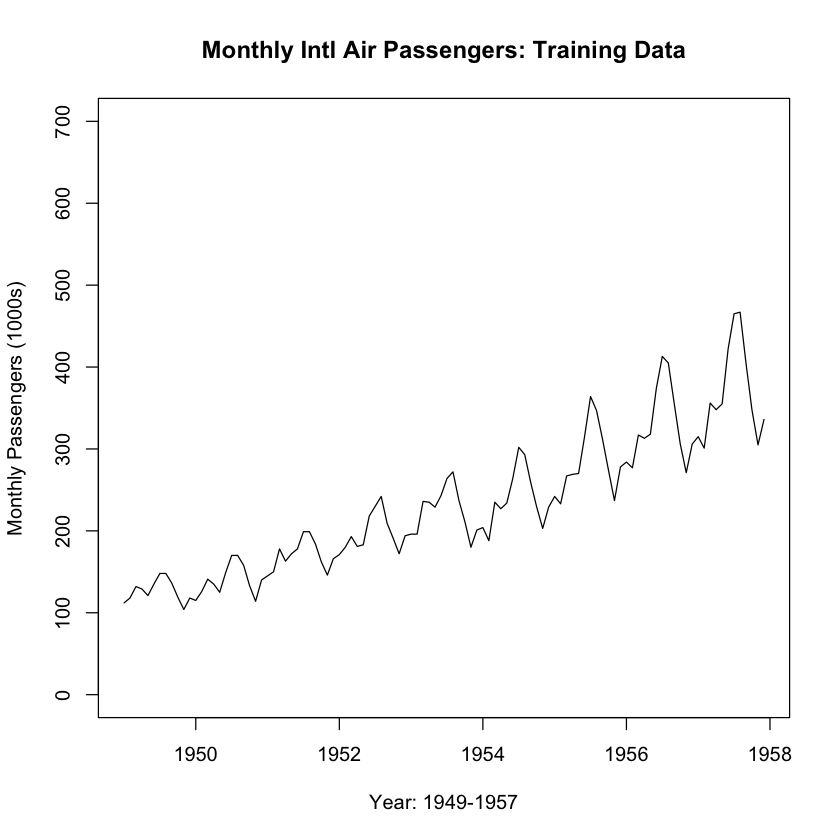

In [7]:
# SPLIT DATA ###############################################

# Use data from 1949 through 1957 for training
trn <- df %>% window(end = c(1957, 12))
trn      # Show data in Console
trn %>%  # Plot data
  plot(
    main = "Monthly Intl Air Passengers: Training Data",
    xlab = "Year: 1949-1957",
    ylab = "Monthly Passengers (1000s)",
    ylim = c(0, 700)
  )

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1958,340,318,362,348,363,435,491,505,404,359,310,337
1959,360,342,406,396,420,472,548,559,463,407,362,405
1960,417,391,419,461,472,535,622,606,508,461,390,432


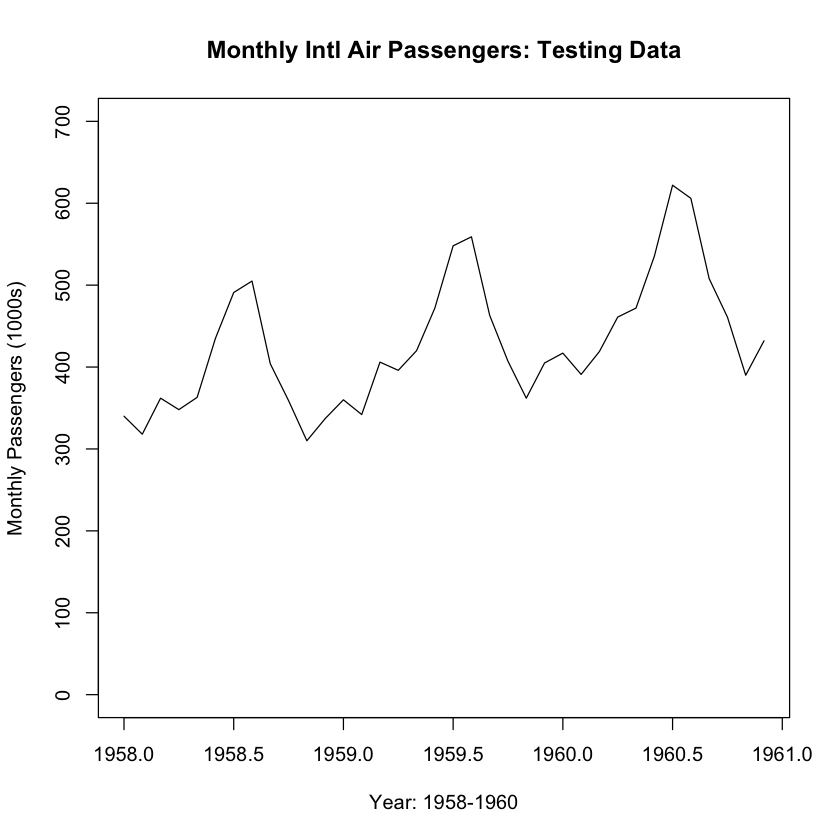

In [8]:
# Use data from 1958 through 1960 for testing
tst <- df %>% window(start = 1958)
tst      # Show data in Console
tst %>%  # Plot data
  plot(
    main = "Monthly Intl Air Passengers: Testing Data",
    xlab = "Year: 1958-1960",
    ylab = "Monthly Passengers (1000s)",
    ylim = c(0, 700)
  )

In [9]:
# FIT MLP MODELS ###########################################

# Fit default MLP model; number of hidden nodes = 5 (can add
# the argument hd.auto.type = "set") (takes a few seconds)
fit1  <- trn  %>% mlp()
pred1 <- fit1 %>% forecast(h = 36)
pred1                                  # Show predictions

          Jan      Feb      Mar      Apr      May      Jun      Jul      Aug
1958 347.2274 333.2331 399.0299 395.6317 398.7499 464.1800 510.1070 512.6805
1959 382.1134 370.1267 440.8533 442.8739 450.2174 513.3792 553.0381 551.7170
1960 441.4548 430.5797 486.0267 490.5347 496.1032 561.4426 606.5845 610.2019
          Sep      Oct      Nov      Dec
1958 451.5667 395.1199 348.4230 371.5992
1959 502.5966 438.0035 396.8563 431.1030
1960 551.8363 496.6722 452.1535 472.6564

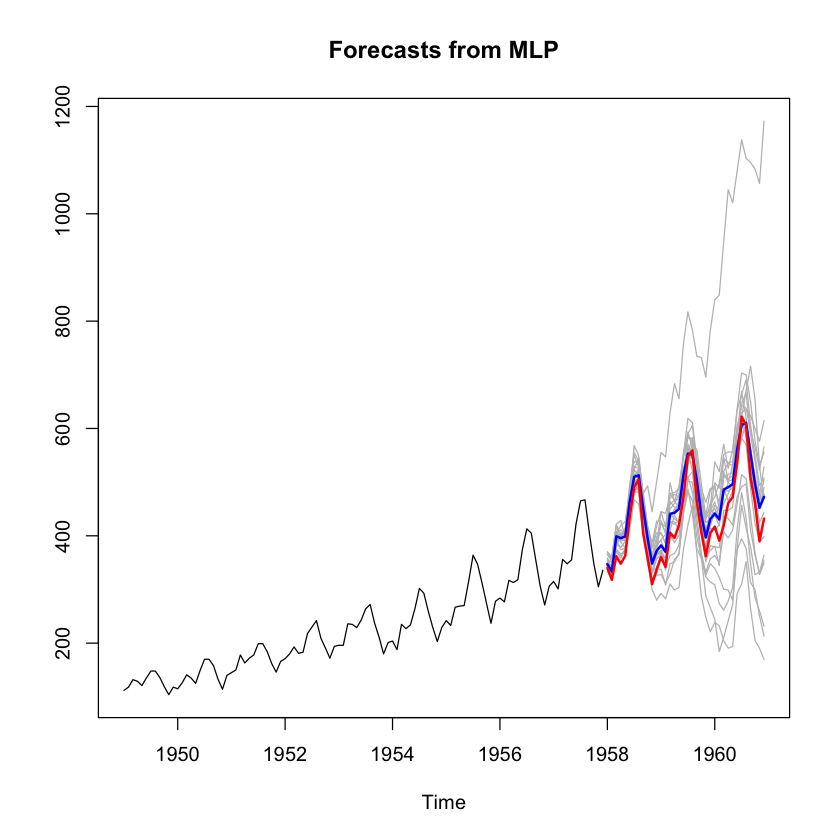

In [12]:
pred1 %>% plot()                       # Plot predictions
tst   %>% lines(lwd = 2, col = "red")  # Plot testing data

In [13]:
# Fit MLP model with number of hidden nodes determined by
# 20% validation (takes a while; 35 seconds on my machine)
fit2  <- trn  %>% mlp(hd.auto.type = "valid")
pred2 <- fit2 %>% forecast(h = 36)
pred2                                  # Show predictions

          Jan      Feb      Mar      Apr      May      Jun      Jul      Aug
1958 343.5230 332.6460 378.8208 368.6622 384.4720 443.9960 488.2297 491.5178
1959 377.2353 369.6409 409.4697 397.0394 416.0100 472.5498 517.3672 521.3102
1960 411.5706 406.3356 441.9693 428.0485 447.6728 502.9210 548.2396 552.8478
          Sep      Oct      Nov      Dec
1958 437.4608 381.0977 338.0657 371.2555
1959 470.9575 415.5753 373.3867 406.2941
1960 503.9926 449.5308 408.5388 440.6395

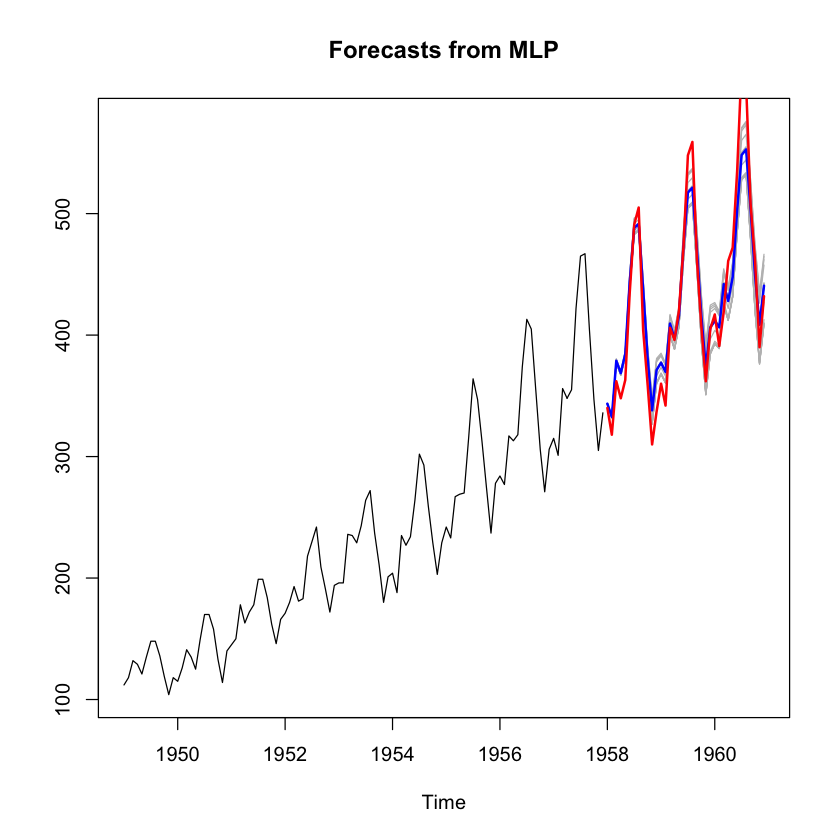

In [14]:
pred2 %>% plot()                       # Plot predictions
tst   %>% lines(lwd = 2, col = "red")  # Plot testing data

In [ ]:
# Fit MLP model with number of hidden nodes determined by
# 5-fold cross-validation (takes an even longer while; about
# 3 minutes on my machine)
fit3  <- trn  %>% mlp(hd.auto.type = "cv")
pred3 <- fit3 %>% forecast(h = 36)
pred3                                  # Show predictions

In [ ]:
pred3 %>% plot()                       # Plot predictions
tst   %>% lines(lwd = 2, col = "red")  # Plot testing data